#### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

### Read Time Series Data

In [2]:
df = pd.read_excel(r'C:\IUPUI\Fall 2023\AppliedEcon&Forecasting\project\data.xlsx')

In [3]:
df.head()

,observation_date,RCCCBBALTOT,q1,q2,q3,q4
0,2012-07-01,531.06,0,0,1,0
1,2012-10-01,546.20,0,0,0,1
2,2013-01-01,517.65,1,0,0,0
3,2013-04-01,524.84,0,1,0,0
4,2013-07-01,524.63,0,0,1,0


In [4]:
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

### Plot Data

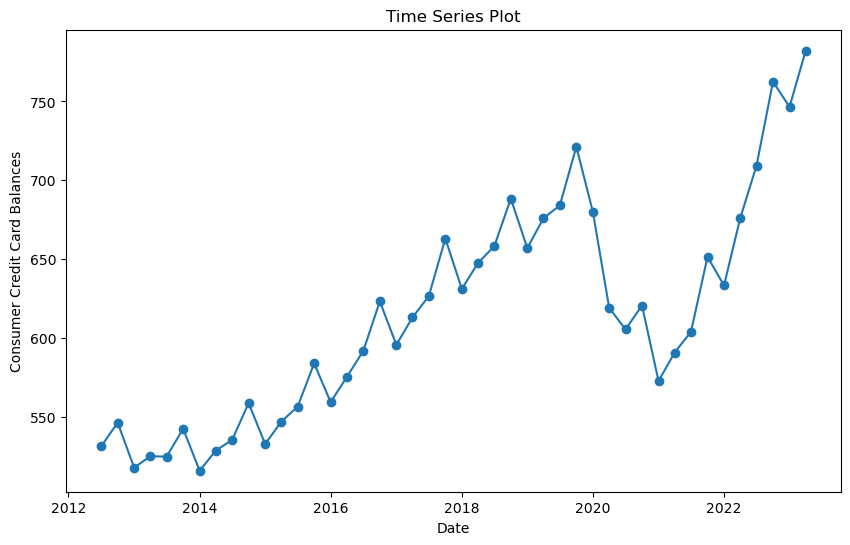

In [5]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['RCCCBBALTOT'], marker='o')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
# plt.grid(True)
plt.show()

### Time Series Decomposition

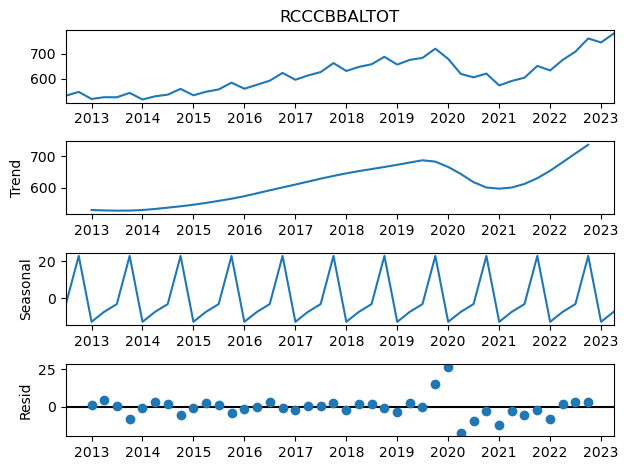

In [6]:
# Perform a seasonal decomposition
# Assuming the data is quarterly, the seasonal period is 4
decomposition = seasonal_decompose(df['RCCCBBALTOT'], model='additive', period=4)

# Plot the seasonal decomposition
decomposition.plot()
plt.show()

### Applying Simple Forecasting Techniques

In [7]:
# Splitting the data into train and test sets
# Using the first observation as train data and the last 4 as test data
train = df.iloc[:-4]
test = df.iloc[-4:]

In [8]:
test

,RCCCBBALTOT,q1,q2,q3,q4
observation_date,,,,,
2022-07-01,709.26,0,0,1,0
2022-10-01,762.56,0,0,0,1
2023-01-01,746.56,1,0,0,0
2023-04-01,782.22,0,1,0,0


In [9]:
# Forecasting methods
def naive_forecast(train, periods):
    return np.array([train.iloc[-1]] * periods)

def average_forecast(train, periods):
    return np.array([train.mean()] * periods)

def seasonal_naive_forecast(train, periods, season_length):
    if -season_length + periods == 0:
        end = None
    else:
        end = -season_length + periods
    return train.iloc[-season_length: end].to_numpy()

def drift_forecast(train, periods):
    n = len(train)
    slope = (train.iloc[-1] - train.iloc[0]) / (n - 1)
    return np.array([train.iloc[-1] + i * slope for i in range(1, periods + 1)])

def moving_average_forecast(train, periods, window_size):
    return np.array([train.rolling(window=window_size).mean().iloc[-1]] * periods)

In [10]:
# Generating forecasts
naive_pred = naive_forecast(train['RCCCBBALTOT'], 4)
average_pred = average_forecast(train['RCCCBBALTOT'], 4)
seasonal_naive_pred = seasonal_naive_forecast(train['RCCCBBALTOT'], 4, 4)  # Using full dataset for seasonal pattern
drift_pred = drift_forecast(train['RCCCBBALTOT'], 4)
moving_average_pred = moving_average_forecast(train['RCCCBBALTOT'], 4, 2)  # Using window size of 2

In [11]:
# Calculating MAE and RMSE
def calculate_errors(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    return mae, rmse

In [12]:
# Errors for each forecast method
naive_errors = calculate_errors(test['RCCCBBALTOT'], naive_pred)
average_errors = calculate_errors(test['RCCCBBALTOT'], average_pred)
seasonal_naive_errors = calculate_errors(test['RCCCBBALTOT'], seasonal_naive_pred)
drift_errors = calculate_errors(test['RCCCBBALTOT'], drift_pred)
moving_average_errors = calculate_errors(test['RCCCBBALTOT'], moving_average_pred)

In [13]:
forecast_errors = {
    "Naive": naive_errors,
    "Average": average_errors,
    "Seasonal Naive": seasonal_naive_errors,
    "Drift": drift_errors,
    "Moving Average": moving_average_errors
}

forecast_errors


{'Naive': (74.28999999999996, 78.96738187378378),
 'Average': (149.96024999999997, 152.3316115586732),
 'Seasonal Naive': (109.05249999999998, 109.10163186222283),
 'Drift': (65.00794871794866, 69.0781711925389),
 'Moving Average': (95.58499999999992, 99.26396891621846)}

### Plotting Simple Forecasts

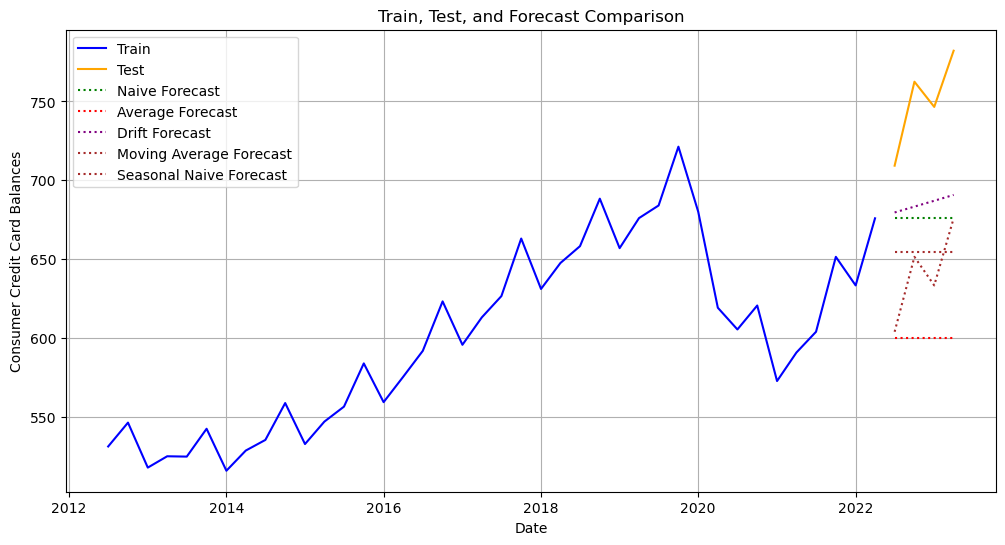

In [14]:
# Plotting the train, test, and forecasts on a single graph
plt.figure(figsize=(12, 6))

# Plotting train and test data
plt.plot(train['RCCCBBALTOT'], label='Train', color='blue')
plt.plot(test['RCCCBBALTOT'], label='Test', color='orange')

# Plotting forecasts
forecast_periods = test.index
plt.plot(forecast_periods, naive_pred, label='Naive Forecast', color='green', linestyle='dotted')
plt.plot(forecast_periods, average_pred, label='Average Forecast', color='red', linestyle='dotted')
plt.plot(forecast_periods, drift_pred, label='Drift Forecast', color='purple', linestyle='dotted')
plt.plot(forecast_periods, seasonal_naive_pred, label='Moving Average Forecast', color='brown', linestyle='dotted')
plt.plot(forecast_periods, moving_average_pred, label='Seasonal Naive Forecast', color='brown', linestyle='dotted')

# Adding titles and labels
plt.title('Train, Test, and Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Creating a DataFrame to compare forecasts
forecast_comparison = pd.DataFrame({
    'Actual': test['RCCCBBALTOT'].values,
    'Naive Forecast': naive_pred,
    'Average Forecast': average_pred,
    'Drift Forecast': drift_pred,
    'Moving Average Forecast': moving_average_pred,
    'Seasonal Naive Forecast':seasonal_naive_pred
}, index=forecast_periods)

# Creating a DataFrame for the errors
forecast_errors_df = pd.DataFrame({
    'Forecast Method': ['Naive', 'Average', 'Drift', 'Moving Average', 'Seasonal Naive Forecast'],
    'MAE': [naive_errors[0], average_errors[0], drift_errors[0], moving_average_errors[0], seasonal_naive_errors[0]],
    'RMSE': [naive_errors[1], average_errors[1], drift_errors[1], moving_average_errors[1], seasonal_naive_errors[1]]
})

forecast_comparison.round(1)

,Actual,Naive Forecast,Average Forecast,Drift Forecast,Moving Average Forecast,Seasonal Naive Forecast
observation_date,,,,,,
2022-07-01,709.3,675.9,600.2,679.6,654.6,603.8
2022-10-01,762.6,675.9,600.2,683.3,654.6,651.4
2023-01-01,746.6,675.9,600.2,687.0,654.6,633.3
2023-04-01,782.2,675.9,600.2,690.7,654.6,675.9


In [16]:
forecast_errors_df.round(1).sort_values(by = "RMSE")

,Forecast Method,MAE,RMSE
2,Drift,65.0,69.1
0,Naive,74.3,79.0
3,Moving Average,95.6,99.3
4,Seasonal Naive Forecast,109.1,109.1
1,Average,150.0,152.3


#### From the methods applied we see the Drift forecasting method to perform best followed by the Naive method

### Additional Forecasting Methods

In [17]:
# Exponential Smoothing (Simple)
exp_smoothing_model = SimpleExpSmoothing(train['RCCCBBALTOT']).fit(smoothing_level=0.2)
exp_smoothing_pred = exp_smoothing_model.forecast(4)

# Double Exponential Smoothing (Holt's Linear)
double_exp_smoothing_model = ExponentialSmoothing(train['RCCCBBALTOT'], trend='add').fit()
double_exp_smoothing_pred = double_exp_smoothing_model.forecast(4)

# Holt-Winters Method
holt_winters_model = ExponentialSmoothing(train['RCCCBBALTOT'], trend='add', seasonal='add', seasonal_periods=4).fit()
holt_winters_pred = holt_winters_model.forecast(4)

In [18]:
exp_smoothing_errors = calculate_errors(test['RCCCBBALTOT'], exp_smoothing_pred)
double_exp_smoothing_errors = calculate_errors(test['RCCCBBALTOT'], double_exp_smoothing_pred)
holt_winters_errors = calculate_errors(test['RCCCBBALTOT'], holt_winters_pred)

In [19]:
forecast_comparison['Exponential Smoothing'] = exp_smoothing_pred
forecast_comparison['Double Exponential Smoothing'] = double_exp_smoothing_pred
forecast_comparison['Holt-Winters'] = holt_winters_pred

In [20]:
forecast_comparison.round(2)

,Actual,Naive Forecast,Average Forecast,Drift Forecast,Moving Average Forecast,Seasonal Naive Forecast,Exponential Smoothing,Double Exponential Smoothing,Holt-Winters
observation_date,,,,,,,,,
2022-07-01,709.26,675.86,600.19,679.57,654.57,603.85,636.45,670.68,708.24
2022-10-01,762.56,675.86,600.19,683.29,654.57,651.41,636.45,674.13,761.61
2023-01-01,746.56,675.86,600.19,687.00,654.57,633.27,636.45,677.59,755.57
2023-04-01,782.22,675.86,600.19,690.71,654.57,675.86,636.45,681.05,789.42


In [21]:
# Updating the forecast errors DataFrame
new_forecast_errors = {
    'Forecast Method': ['Exponential Smoothing', 'Double Exponential Smoothing', 'Holt-Winters'],
    'MAE': [exp_smoothing_errors[0], double_exp_smoothing_errors[0], holt_winters_errors[0]],
    'RMSE': [exp_smoothing_errors[1], double_exp_smoothing_errors[1], holt_winters_errors[1]]
}

forecast_errors_df = forecast_errors_df.append(pd.DataFrame(new_forecast_errors), ignore_index=True)

In [22]:
forecast_comparison

,Actual,Naive Forecast,Average Forecast,Drift Forecast,Moving Average Forecast,Seasonal Naive Forecast,Exponential Smoothing,Double Exponential Smoothing,Holt-Winters
observation_date,,,,,,,,,
2022-07-01,709.26,675.86,600.18975,679.572821,654.565,603.85,636.454328,670.678824,708.242450
2022-10-01,762.56,675.86,600.18975,683.285641,654.565,651.41,636.454328,674.134803,761.609411
2023-01-01,746.56,675.86,600.18975,686.998462,654.565,633.27,636.454328,677.590782,755.569131
2023-04-01,782.22,675.86,600.18975,690.711282,654.565,675.86,636.454328,681.046761,789.422592


In [23]:
forecast_errors_df.sort_values(by="RMSE")

,Forecast Method,MAE,RMSE
7,Holt-Winters,4.544965,5.809062
2,Drift,65.007949,69.078171
6,Double Exponential Smoothing,74.287207,77.942767
0,Naive,74.290000,78.967382
3,Moving Average,95.585000,99.263969
4,Seasonal Naive Forecast,109.052500,109.101632
5,Exponential Smoothing,113.695672,116.805604
1,Average,149.960250,152.331612


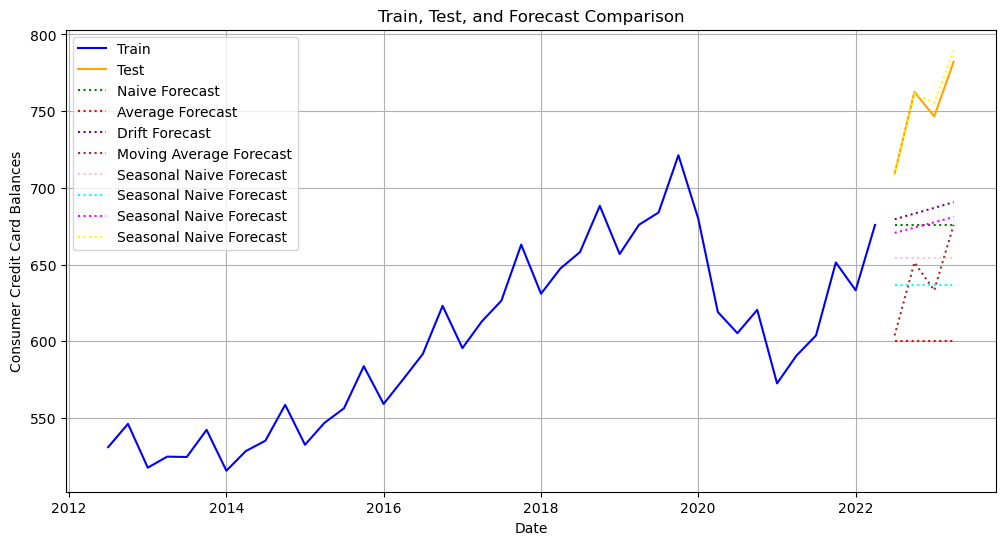

In [24]:
# Plotting the train, test, and forecasts on a single graph
plt.figure(figsize=(12, 6))

# Plotting train and test data
plt.plot(train['RCCCBBALTOT'], label='Train', color='blue')
plt.plot(test['RCCCBBALTOT'], label='Test', color='orange')

# Plotting forecasts
forecast_periods = test.index
plt.plot(forecast_periods, naive_pred, label='Naive Forecast', color='green', linestyle='dotted')
plt.plot(forecast_periods, average_pred, label='Average Forecast', color='red', linestyle='dotted')
plt.plot(forecast_periods, drift_pred, label='Drift Forecast', color='purple', linestyle='dotted')
plt.plot(forecast_periods, seasonal_naive_pred, label='Moving Average Forecast', color='brown', linestyle='dotted')
plt.plot(forecast_periods, moving_average_pred, label='Seasonal Naive Forecast', color='pink', linestyle='dotted')
plt.plot(forecast_periods, exp_smoothing_pred, label='Seasonal Naive Forecast', color='cyan', linestyle='dotted')
plt.plot(forecast_periods, double_exp_smoothing_pred, label='Seasonal Naive Forecast', color='magenta', linestyle='dotted')
plt.plot(forecast_periods, holt_winters_pred, label='Seasonal Naive Forecast', color='yellow', linestyle='dotted')

# Adding titles and labels
plt.title('Train, Test, and Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.legend()
plt.grid(True)
plt.show()

#### From the methods that we have applied we see the Holt Winters forecasting method to perform best followed by the drift method

### Check for Stationarity and Differencing

In [25]:
# Function to perform Dickey-Fuller test
def perform_adfuller_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Perform tests on the dataset
print("Dickey-Fuller Test:")
perform_adfuller_test(train['RCCCBBALTOT'])

Dickey-Fuller Test:
ADF Statistic: -1.285181
p-value: 0.635925
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614


#### The p-value is high indicating the series needs to be differenced

In [26]:
# Regular Differencing
data = train['RCCCBBALTOT']
differenced_data = data - data.shift(1)

In [27]:
# Perform tests on the dataset
print("Dickey-Fuller Test:")
perform_adfuller_test(differenced_data.dropna())

Dickey-Fuller Test:
ADF Statistic: -2.789006
p-value: 0.059861
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


#### After differencing we see the p-value to be at ~0.06 which is little above the critical value of 0.05 but is acceptable.

#### Since the series has a seasonality component we will have to difference the data by seasonality as well

Text(0.5, 1.0, 'Differenced series')

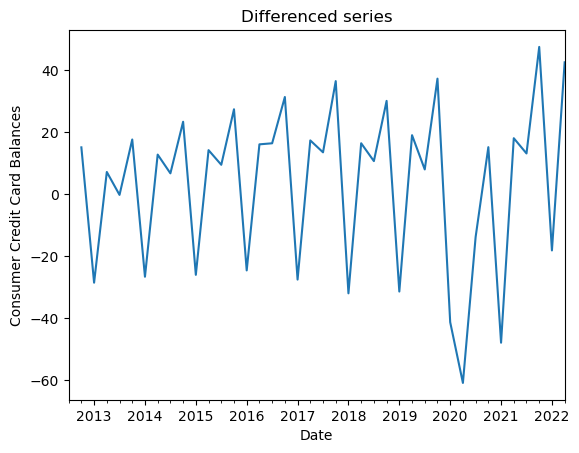

In [28]:
differenced_data.plot()
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.title('Differenced series')

In [29]:
# Seasonal Differencing
seasonal_period = 4
seasonal_differenced_data = differenced_data - differenced_data.shift(seasonal_period)

Text(0.5, 1.0, 'Seasonal Differenced series')

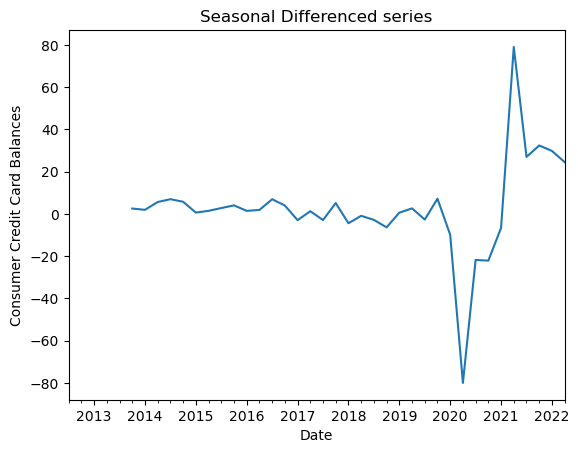

In [30]:
seasonal_differenced_data.plot()
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.title('Seasonal Differenced series')

In [31]:
# Perform tests on the seasonally differenced dataset
print("Dickey-Fuller Test:")
perform_adfuller_test(seasonal_differenced_data.dropna())

Dickey-Fuller Test:
ADF Statistic: -2.637512
p-value: 0.085490
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628


#### After seasonal differencing we see the p-value to be at ~0.085. This is a little above the critical value of 0.05. The test might inflate the value because of the rapid change in the series during covid period

In [32]:
print("Dickey-Fuller Test:")
perform_adfuller_test(seasonal_differenced_data[seasonal_differenced_data.index < "2020-04-01"].dropna())

Dickey-Fuller Test:
ADF Statistic: -4.238568
p-value: 0.000567
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


#### On testing the same we see the p-value to now be far below the critical value of 0.05 proving the series is now stationary

### ACF and PACF plots

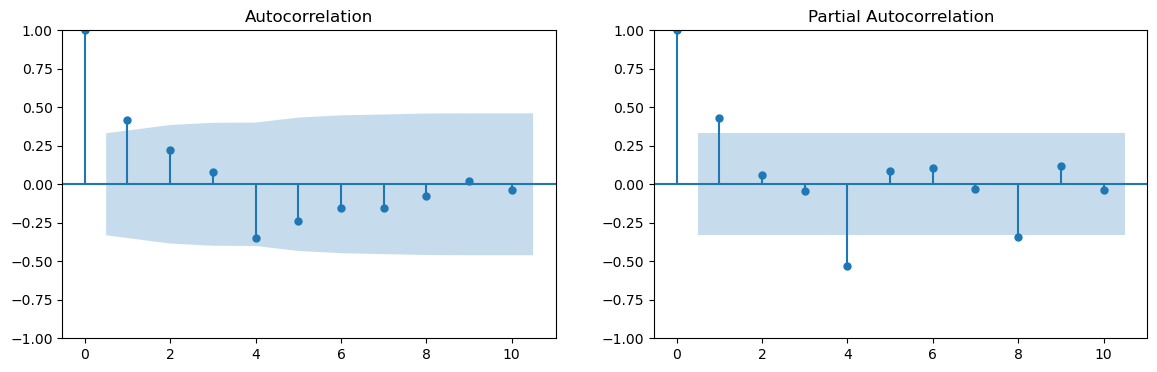

In [33]:
# Using the train dataset from the hypothetical data for ACF and PACF plots
data_for_acf_pacf = seasonal_differenced_data.dropna()

# Plotting ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF plot
sm.graphics.tsa.plot_acf(data_for_acf_pacf, lags=10, ax=axes[0])

# PACF plot
sm.graphics.tsa.plot_pacf(data_for_acf_pacf, lags=10, ax=axes[1])

plt.show()

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### SARIMA Modeling

In [35]:
data_for_acf_pacf = train['RCCCBBALTOT']

# Define specific SARIMA specifications
specs = [
    (1, 1, 1, 0, 1, 1, 4),  # (p, d, q, P, D, Q, s)
    (1, 1, 1, 1, 1, 0, 4),
    (1, 1, 1, 1, 1, 1, 4),
    (2, 1, 2, 2, 1, 0, 4),
    (2, 1, 2, 2, 1, 1, 4),
    (1, 2, 1, 0, 1, 1, 4),
    (1, 2, 2, 0, 1, 1, 4),
    (1, 2, 2, 1, 1, 1, 4),
    (0, 2, 2, 0, 1, 1, 4),
    (2, 2, 2, 0, 1, 1, 4)
]

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'bic'])

# Fit models for each specification
for spec in specs:
    p, d, q, P, D, Q, s = spec
    model = SARIMAX(data_for_acf_pacf, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()
    
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    
    errors = calculate_errors(test['RCCCBBALTOT'], forecast_mean)

    # Store results in DataFrame
    results_df = results_df.append({
        'pdq': (p, d, q),
        'seasonal_pdq': (P, D, Q, s),
        'aic': results.aic,
        'bic': results.bic,
        'mae': errors[0],
        'rmse': errors[1],
    }, ignore_index=True)

# Display the results
print(results_df)
# results_df.to_csv(r"C:\IUPUI\Fall 2023\AppliedEcon&Forecasting\project\sarima_outputs.csv", index = False)

         pdq  seasonal_pdq         aic         bic        mae       rmse
0  (1, 1, 1)  (0, 1, 1, 4)  301.834520  308.055912  29.508055  33.505333
1  (1, 1, 1)  (1, 1, 0, 4)  310.288814  316.510206   4.025077   5.429115
2  (1, 1, 1)  (1, 1, 1, 4)  303.834217  311.610958  29.437505  33.416386
3  (2, 1, 2)  (2, 1, 0, 4)  307.259301  318.146738  24.746789  35.848143
4  (2, 1, 2)  (2, 1, 1, 4)  307.246749  319.689533  30.367656  38.636416
5  (1, 2, 1)  (0, 1, 1, 4)  298.546832  304.652274  11.528094  14.070538
6  (1, 2, 2)  (0, 1, 1, 4)  299.218144  306.849946  21.612297  24.335510
7  (1, 2, 2)  (1, 1, 1, 4)  301.202735  310.360899  22.624534  25.341907
8  (0, 2, 2)  (0, 1, 1, 4)  298.480482  304.585925  10.263020  12.563912
9  (2, 2, 2)  (0, 1, 1, 4)  300.948320  310.106483  30.395829  34.318497


#### Plot best SARIMA

In [42]:
# SARIMA (1, 1, 1)  (1, 1, 0, 4)
s= 4

sarima_model_1111104 = SARIMAX(data_for_acf_pacf, order=(1,1,1), seasonal_order=(1,1,1, s))
results = sarima_model_1111104.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean_sarima_model_1111104 = forecast.predicted_mean

sarima_model_1210114 = SARIMAX(data_for_acf_pacf, order=(1,2,1), seasonal_order=(0,1,1, s))
results = sarima_model_1210114.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean_sarima_model_1210114 = forecast.predicted_mean

sarima_model_0220114 = SARIMAX(data_for_acf_pacf, order=(0,2,2), seasonal_order=(0,1,1, s))
results = sarima_model_0220114.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean_sarima_model_0220114 = forecast.predicted_mean

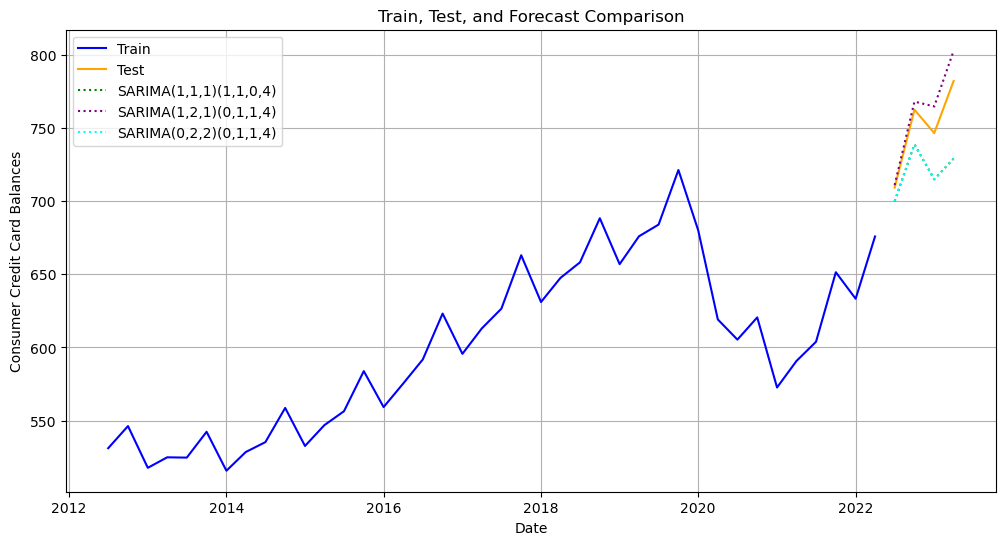

In [47]:
# Plotting the train, test, and forecasts on a single graph
plt.figure(figsize=(12, 6))

# Plotting train and test data
plt.plot(train['RCCCBBALTOT'], label='Train', color='blue')
plt.plot(test['RCCCBBALTOT'], label='Test', color='orange')

# Plotting forecasts
forecast_periods = test.index
plt.plot(forecast_periods, forecast_mean_sarima_model_1111104, label='SARIMA(1,1,1)(1,1,0,4)', color='green', linestyle='dotted')
plt.plot(forecast_periods, forecast_mean_sarima_model_1210114, label='SARIMA(1,2,1)(0,1,1,4)', color='purple', linestyle='dotted')
plt.plot(forecast_periods, forecast_mean_sarima_model_1111104, label='SARIMA(0,2,2)(0,1,1,4)', color='cyan', linestyle='dotted')

# Adding titles and labels
plt.title('Train, Test, and Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.legend()
plt.grid(True)
plt.show()

### Adding a covid index dummy variable

In [36]:
train['covid_index'] = 0
train.loc[(train.index >= '2020-04-01') & (train.index <= '2021-01-01'), 'covid_index'] = 1

In [37]:
train.loc[(train.index >= '2020-04-01'), 'covid_index'] = 1

### SARIMAX Modeling with covid index

In [38]:
data_for_acf_pacf = train['RCCCBBALTOT']

# Define specific SARIMA specifications
specs = [
    (1, 1, 1, 0, 1, 1, 4),  # (p, d, q, P, D, Q, s)
    (1, 1, 1, 1, 1, 0, 4),
    (1, 1, 1, 1, 1, 1, 4),
    (2, 1, 2, 2, 1, 0, 4),
    (2, 1, 2, 2, 1, 1, 4),
    (1, 2, 1, 0, 1, 1, 4),
    (1, 2, 2, 0, 1, 1, 4),
    (1, 2, 2, 1, 1, 1, 4),
    (0, 2, 2, 0, 1, 1, 4),
    (2, 2, 2, 0, 1, 1, 4)
]

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'bic'])

# Fit models for each specification
for spec in specs:
    p, d, q, P, D, Q, s = spec
    model = SARIMAX(data_for_acf_pacf, order=(p, d, q), seasonal_order=(P, D, Q, s), exog = train['covid_index'])
    out_of_sample_covid_index = np.full(len(test), 1) 
    results = model.fit()
    
    forecast = results.get_forecast(steps=len(test), exog = out_of_sample_covid_index)
    forecast_mean = forecast.predicted_mean
    
    errors = calculate_errors(test['RCCCBBALTOT'], forecast_mean)

    # Store results in DataFrame
    results_df = results_df.append({
        'pdq': (p, d, q),
        'seasonal_pdq': (P, D, Q, s),
        'aic': results.aic,
        'bic': results.bic,
        'mae': errors[0],
        'rmse': errors[1],
    }, ignore_index=True)

# Display the results
print(results_df)
# results_df.to_csv(r"C:\IUPUI\Fall 2023\AppliedEcon&Forecasting\project\sarimax_outputs.csv", index = False)

         pdq  seasonal_pdq         aic         bic        mae       rmse
0  (1, 1, 1)  (0, 1, 1, 4)  242.227900  250.004641   9.504366  12.339249
1  (1, 1, 1)  (1, 1, 0, 4)  240.752874  248.529615   7.169192   9.991376
2  (1, 1, 1)  (1, 1, 1, 4)  242.091812  251.423900   8.862350  12.577871
3  (2, 1, 2)  (2, 1, 0, 4)  235.578059  248.020844  55.077641  59.419122
4  (2, 1, 2)  (2, 1, 1, 4)  237.563807  251.561939  54.443476  58.702893
5  (1, 2, 1)  (0, 1, 1, 4)  236.493601  244.125403  28.487568  36.261218
6  (1, 2, 2)  (0, 1, 1, 4)  233.684712  242.842875  23.361630  30.580780
7  (1, 2, 2)  (1, 1, 1, 4)  232.173436  242.857960  21.678346  29.453727
8  (0, 2, 2)  (0, 1, 1, 4)  232.721567  240.353370  25.761042  33.397030
9  (2, 2, 2)  (0, 1, 1, 4)  234.956538  245.641061  19.201080  26.650730


In [39]:
model_summary = results.summary()
print(model_summary)

                                      SARIMAX Results                                      
Dep. Variable:                         RCCCBBALTOT   No. Observations:                   40
Model:             SARIMAX(2, 2, 2)x(0, 1, [1], 4)   Log Likelihood                -110.478
Date:                             Thu, 14 Dec 2023   AIC                            234.957
Time:                                     22:25:08   BIC                            245.641
Sample:                                 07-01-2012   HQIC                           238.600
                                      - 04-01-2022                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_index   -65.7384      5.660    -11.615      0.000     -76.832     -54.645
ar.L1           1.0374  

#### Plot Best SARIMAX

In [48]:
# SARIMAX (1, 1, 1)  (1, 1, 0, 4)
sarimax_model_1111104 = SARIMAX(data_for_acf_pacf, order=(1,1,1), seasonal_order=(1,1,1,s), exog = train['covid_index'])
out_of_sample_covid_index = np.full(len(test), 1)
results = sarimax_model_1111104.fit()
forecast = results.get_forecast(steps=len(test), exog = out_of_sample_covid_index)
forecast_mean_sarimax_model_1111104 = forecast.predicted_mean

# SARIMAX (1, 2, 2)  (1, 1, 1, 4)
sarimax_model_1221114 = SARIMAX(data_for_acf_pacf, order=(1,2,2), seasonal_order=(1,1,1,s), exog = train['covid_index'])
out_of_sample_covid_index = np.full(len(test), 1)
results = sarimax_model_1221114.fit()
forecast = results.get_forecast(steps=len(test), exog = out_of_sample_covid_index)
forecast_mean_sarimax_model_1221114 = forecast.predicted_mean

# SARIMAX (0, 2, 2)  (0, 1, 1, 4)
sarimax_model_0220114 = SARIMAX(data_for_acf_pacf, order=(0, 2, 2), seasonal_order=(0,1,1,s), exog = train['covid_index'])
out_of_sample_covid_index = np.full(len(test), 1)
results = sarimax_model_0220114.fit()
forecast = results.get_forecast(steps=len(test), exog = out_of_sample_covid_index)
forecast_mean_sarimax_model_0220114 = forecast.predicted_mean

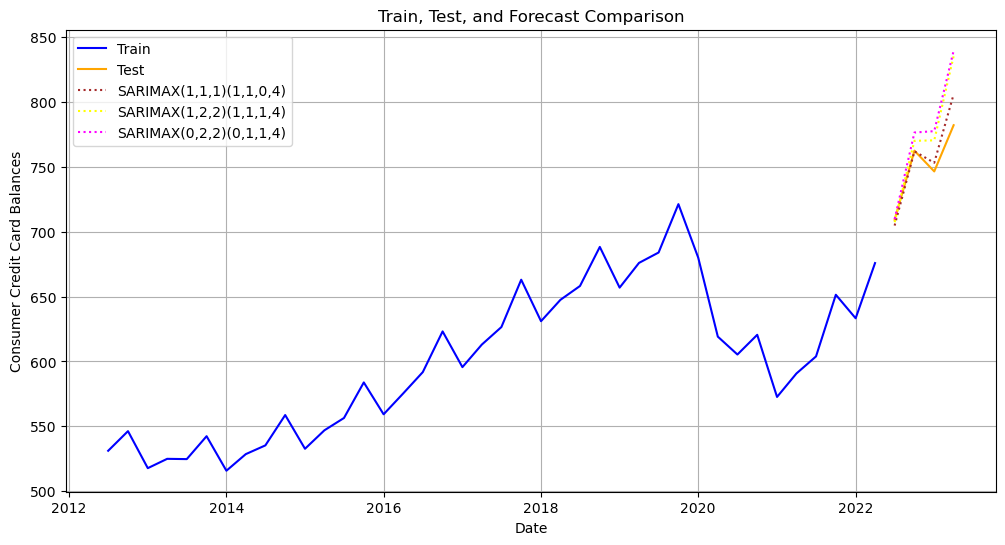

In [50]:
# Plotting the train, test, and forecasts on a single graph
plt.figure(figsize=(12, 6))

# Plotting train and test data
plt.plot(train['RCCCBBALTOT'], label='Train', color='blue')
plt.plot(test['RCCCBBALTOT'], label='Test', color='orange')

# Plotting forecasts
forecast_periods = test.index
plt.plot(forecast_periods, forecast_mean_sarimax_model_1111104, label='SARIMAX(1,1,1)(1,1,0,4)', color='brown', linestyle='dotted')
plt.plot(forecast_periods, forecast_mean_sarimax_model_1221114, label='SARIMAX(1,2,2)(1,1,1,4)', color='yellow', linestyle='dotted')
plt.plot(forecast_periods, forecast_mean_sarimax_model_0220114, label='SARIMAX(0,2,2)(0,1,1,4)', color='magenta', linestyle='dotted')

# Adding titles and labels
plt.title('Train, Test, and Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.legend()
plt.grid(True)
plt.show()

### Plot Best SARIMA, SARIMAX Model Specifications

In [67]:
# SARIMA (1, 1, 1)  (1, 1, 0, 4)
s= 4

sarima_model_1111104 = SARIMAX(data_for_acf_pacf, order=(1,1,1), seasonal_order=(1,1,1, s))
results = sarima_model_1111104.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean_sarima_model_1111104 = forecast.predicted_mean


# SARIMAX (1, 1, 1)  (1, 1, 0, 4)
sarimax_model_1111104 = SARIMAX(data_for_acf_pacf, order=(1,1,1), seasonal_order=(1,1,1,s), exog = train['covid_index'])
out_of_sample_covid_index = np.full(len(test), 1)
results = sarimax_model_1111104.fit()
forecast = results.get_forecast(steps=len(test), exog = out_of_sample_covid_index)
forecast_mean_sarimax_model_1111104 = forecast.predicted_mean

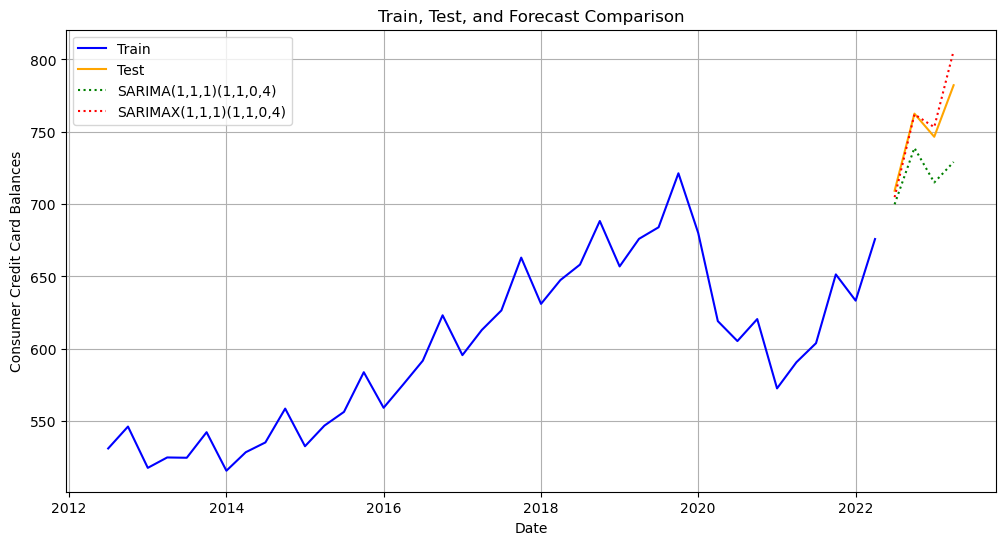

In [69]:
# Plotting the train, test, and forecasts on a single graph
plt.figure(figsize=(12, 6))

# Plotting train and test data
plt.plot(train['RCCCBBALTOT'], label='Train', color='blue')
plt.plot(test['RCCCBBALTOT'], label='Test', color='orange')

# Plotting forecasts
forecast_periods = test.index
plt.plot(forecast_periods, forecast_mean_sarima_model_1111104, label='SARIMA(1,1,1)(1,1,0,4)', color='green', linestyle='dotted')
plt.plot(forecast_periods, forecast_mean_sarimax_model_1111104, label='SARIMAX(1,1,1)(1,1,0,4)', color='red', linestyle='dotted')

# Adding titles and labels
plt.title('Train, Test, and Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Consumer Credit Card Balances')
plt.legend()
plt.grid(True)
plt.show()